In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.preprocessing import image 
import os
import glob
import cv2  # it is used for preprocessing
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.optimizers import *
from keras.callbacks import *
from keras.utils import *
from sklearn.metrics import confusion_matrix
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
%matplotlib inline

 Loading Chest X-Ray Images (Pneumonia) Dataset

Split dataset

In [4]:
print(os.listdir('/content/drive/MyDrive/Data'))

['train', 'validation', 'test']


In [5]:
data_dir = Path('/content/drive/MyDrive/Data')
train_dir = data_dir/'/content/drive/MyDrive/Data/train'
test_dir = data_dir/'/content/drive/MyDrive/Data/test'
val_dir = data_dir/'/content/drive/MyDrive/Data/validation'

In [6]:
def load_train():
  normal_cases_dir=train_dir /'NORMAL'
  pneumonia_cases_dir=train_dir / 'PNEUMONIA'

  normal_cases=normal_cases_dir.glob('*.jpg')
  pneumonia_cases=pneumonia_cases_dir.glob('*.jpg')

  train_data=[]
  train_label=[]
  for img in normal_cases:
    train_data.append(img)
    train_label.append('NORMAL')
  for img in  pneumonia_cases:
    train_data.append(img)
    train_label.append('PNEUMONIA')

  df=pd.DataFrame(train_data,columns=range(1))
  df.columns=['images']
  df['labels']=train_label
  df=df.sample(frac=1).reset_index(drop=True)
  return df

In [7]:
train_data = load_train()
train_data.shape

(4584, 2)

<BarContainer object of 2 artists>

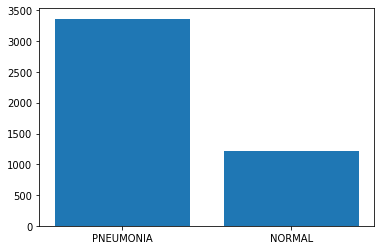

In [8]:
plt.bar(train_data['labels'].value_counts().index,train_data['labels'].value_counts().values)

In [9]:
for col in train_data.columns:
  print(col)

images
labels


Let’s visualize some of these x-rays and see what these images actually look like. We’ll showcase some randomly selected images from our training data.

In [10]:
def plot(image_batch, label_batch):
  plt.figure(figsize=(10,5))
  for i in range(10):
    ax=plt.subplot(2,5,i+1)
    img=cv2.imread(str(image_batch[i]))
    img=cv2.resize(img,(224,224))
    plt.imshow(img)
    plt.title(label_batch[i])
    plt.axis("off")

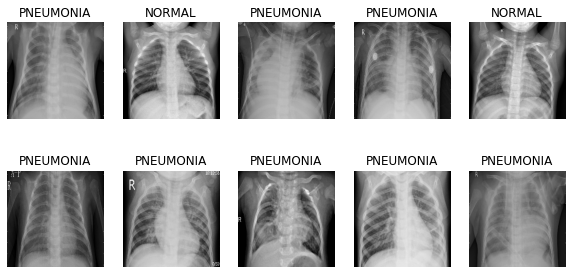

In [11]:
plot(train_data['images'],train_data['labels'])

 Image Classification Model Python - Data Pre-Processing

In [12]:
def prepare_and_load(isval=True):
  if isval==True:
     normal_dir = val_dir/'NORMAL'  
     pneumonia_dir = val_dir/'PNEUMONIA'
  else:
     normal_dir = test_dir/'NORMAL'
     pneumonia_dir = test_dir/'PNEUMONIA'
  #finding jpeg type value
  normal_cases = normal_dir.glob('*.jpg')
  pneumonia_cases = pneumonia_dir.glob('*.jpg')
  data,labels = ([] for x in range(2))
  def prepare(case):
    for img in case:
        img = cv2.imread(str(img))   #convert image into string
        img = cv2.resize(img,(224,224))   #resize image
        if img.shape[2]==1:
            img = np.dstack([img,img,img])  # we r doing this beacuse,
           #Some images are in  greyscale (1 channel), therefore convert them to 3 channel
         #Now convert image to RGB from BGR
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
         #Normalize the image pixels by dividing them by 255 
         #(an essential math trick for better performance).
        img = img.astype(np.float32)/255
         #to_categorical is used to convert labels to one-hot encoded format.
        if case == normal_cases:
             #If img is normal then it will go to label 0
             label = to_categorical(0,num_classes=2)
        else:
             #else it will got label 1 & i mean pneumonia
             label = to_categorical(1,num_classes=2)
        data.append(img)
        labels.append(label)
    return data,labels


  prepare(normal_cases)
  d,l = prepare(pneumonia_cases)
  d = np.array(d)
  l = np.array(l)
  return d,l

 

In [13]:
val_data ,val_labels = prepare_and_load(isval=True)
test_data, test_labels = prepare_and_load(isval  = False)
print('Number of Test Images: ',len(test_data))
print('Number of Validation Images: ',len(val_data))

Number of Test Images:  1052
Number of Validation Images:  240


In [14]:
def data_gen(data,batch_size):
    #get total Number of sample in data
    n = len(data)
    steps =n//batch_size
    #define two numpty arrays for containg batch & labeol data
    batch_data = np.zeros((batch_size,224,224,3),dtype=np.float32)
    batch_labels = np.zeros((batch_size,2),dtype=np.float32)

    #get a numpty aray 
    indices = np.arange(n)
    i = 0
    while True:
        np.random.shuffle(indices)
        #get the next batch
        count = 0
        next_batch = indices[(i*batch_size):(i-1)*batch_size]
        for j,idx in enumerate(next_batch):
            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            if label=='NORMAL':
                label=0
            else:
                label=1

            #one hot encoding
            encoded_label = to_categorical(label,num_classes=2)
            img = cv2.imread(str(img_name))
            img = cv2.resize(img,(224,224))

            #check if its shape is grayscale
            if img.shape[2]==1:
                img = np.dstack([img,img,img])
            #convert color to rgb
            orig_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            #NORMALIZE
            orig_img = img.astype(np.float32)/255
            batch_data[count]=orig_img
            batch_labels[count]=encoded_label
            count = count +1

            if count==batch_size-1:
              break
        i += 1
        yield batch_data,batch_labels
        #Yield is generally used to convert a regular Python function into a generator
        if i>=steps:
          i=0


Add layer to model & using CNN

In [15]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) #used to turn our matric to vector 

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax')) #softmax is activation function for n



In [16]:
batch_size = 15
nb_epochs = 5

#Get trian data genrator
train_data_gen = data_gen(data=train_data,batch_size=batch_size)

#Define number of traing steps
nb_train_steps = train_data.shape[0]//batch_size

print('number of training a validation steps: {} and {}'.format(nb_train_steps,len(val_data)))
#print(f'Number of traing & validation steps: ',nb_train_steps,len(val_data))
#print('Number of traing & validation steps :{} and {}'.format(nb_train_steps),len(val_data)))

number of training a validation steps: 305 and 240


In [17]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history=model.fit_generator(train_data_gen,epochs=nb_epochs,steps_per_epoch=nb_train_steps,
                            validation_data=(val_data,val_labels))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
305/305 [==============================] - 289s 943ms/step - loss: 0.1173 - accuracy: 0.9554 - val_loss: 2.2072 - val_accuracy: 0.6458
Epoch 2/5
305/305 [==============================] - 289s 944ms/step - loss: 0.0400 - accuracy: 0.9921 - val_loss: 3.9099 - val_accuracy: 0.6792
Epoch 3/5
305/305 [==============================] - 294s 961ms/step - loss: 0.0864 - accuracy: 0.9410 - val_loss: 3.5530 - val_accuracy: 0.7208
Epoch 4/5
305/305 [==============================] - 292s 951ms/step - loss: 0.0812 - accuracy: 0.9523 - val_loss: 4.9747 - val_accuracy: 0.6625
Epoch 5/5
305/305 [==============================] - 291s 951ms/step - loss: 0.0364 - accuracy: 0.9287 - val_loss: 3.9544 - val_accuracy: 0.6167


Transfer Learning

In [18]:
def vgg16_model(num_classes=None):
    model = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
    
    x = Dense(1024,activation='relu')(model.layers[-4].output)
    x = Dropout(0.7)(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2,activation='softmax')(x)
   # model = Model(input=input, output=x)
    model = tf.keras.Model(model.input, outputs=x)
    #return model
    return model
    

In [19]:
vgg_conv = vgg16_model(2)
for y in vgg_conv.layers[:-10]:
   y.trainable = False


553476096/553467096 [==============================] - 7s 0us/step


In [20]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001,decay=1e-5)
vgg_conv.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=opt)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history=model.fit_generator(train_data_gen,epochs=nb_epochs,steps_per_epoch=nb_train_steps,
                            validation_data=(val_data,val_labels),class_weight={0:1.0,1:0.4})

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


305/305 [==============================] - 298s 975ms/step - loss: 0.0426 - accuracy: 0.9910 - val_loss: 7.1126 - val_accuracy: 0.4583
Epoch 2/5
305/305 [==============================] - 291s 955ms/step - loss: 0.0208 - accuracy: 0.9948 - val_loss: 29.9913 - val_accuracy: 0.4167
Epoch 3/5
 95/305 [========>.....................] - ETA: 3:22 - loss: 0.1469 - accuracy: 0.9263

In [ ]:
loss,acc = vgg_conv.evaluate(test_data,test_labels,batch_size=16)
print("Loss & accuracy: ",loss," ",acc)

66/66 [==============================] - 535s 8s/step - loss: 0.7607 - accuracy: 0.3222
Loss & accuracy:  0.7607340216636658   0.322243332862854


Evaluating the performance of the image classification Model

In [ ]:
pred = vgg_conv.predict(test_data,batch_size=16)